# Make a chi2 spectrum fit with mixed Fermi/HGPS data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pprint import pprint
import astropy.units as u
from astropy.units import Quantity
from astropy.table import Table, vstack

# Temporarily fixing environment variable for gamma-cat
import os
os.environ['GAMMA_CAT'] = os.path.join('C:/Users/Arjun/github/gamma-cat')

## The source

[HESS J1507-622](https://github.com/gammasky/fermi-hgps-paper/blob/master/analysis/plots/seds/HESS_J1507m622_sed_0.png) (this picture is from the new HESS data, I won't be using it).

- gamma-sky.net: http://gamma-sky.net/#/cat/tev/77

- gamma-cat: source id 77

- AKA 3FGL J1506.6-6219 (3FGL) and 2FHL J1507.4-6213 (2FHL)

- unidentified source. 

- I want to fit a LogParabola spectral model to this source.


In [2]:
# Preparing Fermi data
from gammapy.catalog import SourceCatalog3FGL

cat_f = SourceCatalog3FGL()
source_f = cat_f['3FGL J1506.6-6219']

data_f = source_f.flux_points.table

dnde_err_f = data_f['dnde'] * (data_f['flux_errn'] / data_f['flux'])
data_f['dnde_err'] = dnde_err_f.to(data_f['dnde'].unit)

In [3]:
# Preparing gamma-cat data
from gammapy.catalog import SourceCatalogGammaCat

cat_g = SourceCatalogGammaCat()
source_g = cat_g['HESS J1507-622']

data_f['e_ref'] = data_f['e_ref'].to('TeV')
data_f['e_min'] = data_f['e_min'].to('TeV')
data_f['e_max'] = data_f['e_max'].to('TeV')

data_g = source_g.flux_points.table
dnde_err_g = data_g['dnde'] * (data_g['dnde_errn'] / data_g['dnde'])
data_g['dnde_err'] = dnde_err_g.to(data_g['dnde'].unit)

In [4]:
print("Spectral info from Fermi:\n")

data_f.info()

print('\n', source_f.spectral_model.parameters)

Spectral info from Fermi:

<Table length=5>
   name     dtype        unit      n_bad
---------- ------- --------------- -----
     e_ref float64             TeV     0
     e_min float64             TeV     0
     e_max float64             TeV     0
      flux float32     1 / (cm2 s)     1
 flux_errn float32     1 / (cm2 s)     1
 flux_errp float32     1 / (cm2 s)     1
     eflux float32   erg / (cm2 s)     1
eflux_errn float32   erg / (cm2 s)     1
eflux_errp float32   erg / (cm2 s)     1
     is_ul    bool                     0
   flux_ul float64     1 / (cm2 s)     4
  eflux_ul float64   erg / (cm2 s)     4
      dnde float64 1 / (cm2 s TeV)     0
  dnde_err float64 1 / (cm2 s TeV)     1

 ParameterList
Parameter(name='index', value=1.8567168712615967, unit=Unit(dimensionless), min=0, max=None, frozen=False)
Parameter(name='amplitude', value=2.013417644414206e-14, unit=Unit("1 / (cm2 MeV s)"), min=0, max=None, frozen=False)
Parameter(name='reference', value=6664.8046875, unit=Unit("

In [56]:
print("Spectral info from H.E.S.S.:\n")

data_g.info()

print('\n', source_g.spectral_model.parameters)

Spectral info from H.E.S.S.:

<Table length=6>
   name    dtype        unit      n_bad
--------- ------- --------------- -----
    e_ref float32             TeV     0
     dnde float32 1 / (cm2 s TeV)     0
dnde_errp float32 1 / (cm2 s TeV)     0
dnde_errn float32 1 / (cm2 s TeV)     0
  dnde_ul float32 1 / (cm2 s TeV)     6
 dnde_err float32 1 / (cm2 s TeV)     0

 ParameterList
Parameter(name='index', value=2.490000009536743, unit=Unit(dimensionless), min=0, max=None, frozen=False)
Parameter(name='amplitude', value=3.100000074349185e-12, unit=Unit("1 / (cm2 s TeV)"), min=0, max=None, frozen=False)
Parameter(name='reference', value=1.0, unit=Unit("TeV"), min=None, max=None, frozen=True)

Covariance: [[  3.24000026e-02   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   6.39999978e-25   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]]


## Combining source data

`data_combined` contains all data from SourceCatalog3FGL and SourceCatalogGammaCat in the columns `e_ref`, `dnde`, and `dnde_err`.

In [6]:
colnames=['e_ref', 'dnde', 'dnde_err']

data_combined = vstack([
                    data_f[colnames], 
                    data_g[colnames]
                    ])

data_combined

e_ref,dnde,dnde_err
TeV,1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64
0.000173205080757,0.000180007080937,5.71533417236e-05
0.000547722557505,2.17380797837e-07,nan
0.00173205080757,2.52993839033e-07,1.00000774199e-07
0.00547722557505,2.65716043394e-08,7.94052959033e-09
0.0316227766017,1.27980441338e-09,3.67413027204e-10
0.860900402069,2.29119002416e-12,8.70542678742e-13
1.56151199341,6.98171717921e-13,2.20354116898e-13
2.76375293732,1.69061501452e-13,6.75869814759e-14


## Plot data and model

We'll be plotting the spectral model for the source as given by `SourceCatalogObject3FGL`.

<Container object of 3 artists>

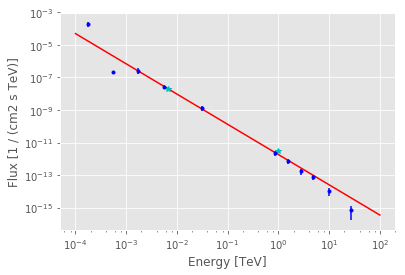

In [7]:
# Defining units
energy_range = [1e-4, 100] * u.TeV
opts = dict(energy_unit='TeV', flux_unit='cm-2 s-1 TeV-1', energy_range=energy_range)

source_f.spectral_model.plot(**opts, color='r')
# Using the combined energy range to stretch to gamma-cat data

p_f = source_f.spectral_model.parameters
p_g = source_g.spectral_model.parameters
plt.plot(p_f['reference'].value / 1e6, p_f['amplitude'].value * 1e6, '*', color='c')
plt.plot(p_g['reference'].value, p_g['amplitude'].value, '*', color='c')



# Combined 3FGL + gamma-cat:
# TODO: Split the colors for the flux points (first 5 purple, last 6 red)
# Instead of the below code, I can call plt.errorbar() for each catalog individually. 

plt.errorbar(x=data_combined['e_ref'],
             y=data_combined['dnde'],
             yerr=data_combined['dnde_err'],
             fmt='.',
             color='b'
            )

## Defining chi2 function

In [66]:
def chi2(amplitude, index):
    
    dnde_model = source_g.spectral_model.evaluate(
        energy=data_combined['e_ref'],
        amplitude=amplitude,
        index=index,
        reference=p_g['reference'].value
    ) 

    chi = (data_combined['dnde'] - dnde_model) / data_combined['dnde_err']
    return np.sum(chi ** 2)

## Maximum likelihood fit

In [67]:
from iminuit import Minuit

pars = dict(amplitude=p_g['amplitude'].value, index=p_g['index'].value)

minuit = Minuit(chi2, **pars)

minuit.print_initial_param()
print("^ Initial parameters")

minuit.migrad() # Performs the minimization
print("^ Optimized parameters for best-fit model")

C:\Users\Arjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: InitialParamWarning: errordef is not given. Default to 1.
  """
C:\Users\Arjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: InitialParamWarning: Parameter amplitude is floating but does not have initial step size. Assume 1.
  """
C:\Users\Arjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: InitialParamWarning: Parameter index is floating but does not have initial step size. Assume 1.
  """


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,amplitude,3.1e-12,1,0,0,,,
2,index,2.49,1,0,0,,,


^ Initial parameters


C:\Users\Arjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    amplitude = +0.000000
        index = +2.490000

  # Remove the CWD from sys.path while we load stuff.
C:\Users\Arjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    amplitude = +nan
        index = +2.490000

  # Remove the CWD from sys.path while we load stuff.
C:\Users\Arjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    amplitude = +0.000000
        index = +nan

  # Remove the CWD from sys.path while we load stuff.
C:\Users\Arjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    amplitude = -nan(ind)
        index = -nan(ind)

  # Remove the CWD from sys.path while we load stuff.
C:\Users\Arjun\Ana

FCN = nan 
 TOTAL NCALL = 36 
 NCALLS = 36 
 
 
 EDM = nan 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,amplitude,nan,nan,0,0,,,
2,index,nan,nan,0,0,,,


^ Optimized parameters for best-fit model


In [51]:
print(minuit.values)
print(minuit.errors)

{'index': nan, 'amplitude': nan}
{'index': nan, 'amplitude': nan}


## Final plot

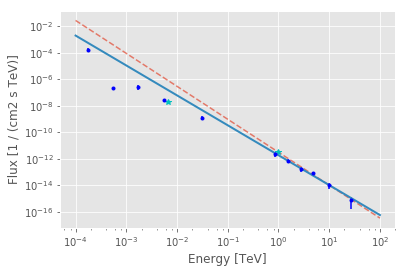

In [10]:
source_g.spectral_model.plot(linestyle='dashed', alpha=0.7, **opts)

plt.plot(p_f['reference'].value / 1e6, p_f['amplitude'].value * 1e6, '*', color='c')
plt.plot(p_g['reference'].value, p_g['amplitude'].value, '*', color='c')

plt.errorbar(x=data_combined['e_ref'],
             y = data_combined['dnde'],
             yerr = data_combined['dnde_err'],
             fmt='.',
             color='b'
            )


from gammapy.utils.energy import Energy
energy = Energy.equal_log_spacing(
    emin=energy_range[0],
    emax=energy_range[1],
    nbins=100,
)

flux = source_g.spectral_model.evaluate(
    energy=energy.to('TeV').value,
    amplitude = minuit.values['amplitude'],
    index = minuit.values['index'],
    reference=p_g['reference'].value,
)
plt.plot(energy, flux, linewidth=2)